In [1]:
# My numpy arrays are stored in google drive. 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# importing the libraries
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
# mapping emotion to index
emotion_to_index = {'angry':0,
                   'fearful':1,
                   'happy':2,
                   'neutral':3,
                   'sad':4,
                   'surprised':5}
index_to_emotion = {0: 'angry',
                    1: 'fearful',
                    2: 'happy',
                    3: 'neutral',
                    4: 'sad',
                    5: 'surprised'}
 
emotions = list(emotion_to_index.keys())

In [3]:
# Lets load up the files
X_train = np.load('gdrive/My Drive/facedata/X_train.npy')
X_test = np.load('gdrive/My Drive/facedata/X_test.npy')
Y_train = np.load('gdrive/My Drive/facedata/Y_train.npy')
Y_test = np.load('gdrive/My Drive/facedata/Y_test.npy')
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((28273, 48, 48, 3), (28273, 1), (7067, 48, 48, 3), (7067, 1))

This is happy


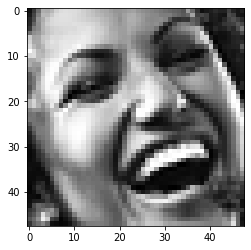

In [4]:
# visualizing the files based on index
index = 2000
img = X_train[index,:,:,:]
print(f"This is {index_to_emotion[Y_train[index, 0]]}")
img = img.astype(np.uint8)
plt.imshow(img, cmap='Greys')
plt.show()

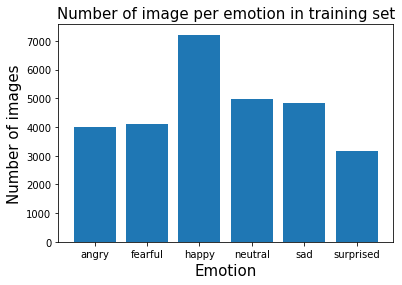

In [5]:
# number of images pertaining to each class
arr = np.zeros((6,))
for i in range(X_train.shape[0]):
    val = np.uint8(Y_train[i])
    arr[val] = arr[val] + 1
#for i in range(7):
#  print(f"{index_to_emotion[i]} has {arr[i,0]}")
arr2 = np.reshape(arr, (-1))
plt.bar([0,1,2,3,4,5], arr2)
plt.xlabel("Emotion", fontsize = 15)
plt.ylabel("Number of images", fontsize = 15)
plt.title("Number of image per emotion in training set", fontsize=15)
 
plt.xticks([0,1,2,3,4,5], emotions)
 
plt.show()

As we can see, the number of images for the emotion disgust is quite low and the distribution for images is not quite same. Hence we will be using f1 score of model as an evaluation metric.

In [6]:
# preproceesing the images
# scaling the X arrays
X_train_proc = X_train/255.
X_test_proc = X_test/255.
# one hot encoding the Y arrays
Y_train_proc = np.squeeze(np.array(tf.one_hot(Y_train,6, axis=1)))
Y_test_proc = np.squeeze(np.array(tf.one_hot(Y_test,6, axis=1)))
Y_train_proc.shape, Y_test_proc.shape

((28273, 6), (7067, 6))

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D, Input

In [8]:
input = Input(shape=(48,48,3))
x = Conv2D(64, (5,5), activation='relu')(input)
x = BatchNormalization()(x)
x = MaxPooling2D((3,3), strides=2)(x)
x = Dropout(0.25)(x)
x = Conv2D(128, (5,5), activation='relu')(x)
x = MaxPooling2D((3,3), strides=2)(x)
x = Dropout(0.2)(x)
x = Conv2D(256, (4,4), activation='relu')(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(6, activation='softmax')(x)
model = Model(inputs=input, outputs=output)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 44, 44, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 44, 44, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 128)       204928

In [10]:
# compiling the model with adam optimizer
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001, decay=0.0001 / 40)
 
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.Precision(),
                                                                           tf.keras.metrics.Recall(),
                                                                           'accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
history = model.fit(X_train_proc, Y_train_proc, epochs=32, verbose=1, validation_data=(X_test_proc, Y_test_proc))

Epoch 1/32
884/884 [==============================] - 23s 20ms/step - loss: 1.5543 - precision: 0.6960 - recall: 0.1070 - accuracy: 0.3726 - val_loss: 1.4054 - val_precision: 0.7968 - val_recall: 0.1637 - val_accuracy: 0.4544
Epoch 2/32
884/884 [==============================] - 12s 13ms/step - loss: 1.3423 - precision: 0.7401 - recall: 0.2302 - accuracy: 0.4714 - val_loss: 1.2934 - val_precision: 0.8038 - val_recall: 0.2237 - val_accuracy: 0.4955
Epoch 3/32
884/884 [==============================] - 12s 13ms/step - loss: 1.2303 - precision: 0.7471 - recall: 0.2982 - accuracy: 0.5225 - val_loss: 1.2680 - val_precision: 0.7372 - val_recall: 0.2863 - val_accuracy: 0.5165
Epoch 4/32
884/884 [==============================] - 10s 11ms/step - loss: 1.1479 - precision: 0.7560 - recall: 0.3509 - accuracy: 0.5581 - val_loss: 1.1497 - val_precision: 0.7810 - val_recall: 0.3412 - val_accuracy: 0.5622
Epoch 5/32
884/884 [==============================] - 10s 11ms/step - loss: 1.0741 - precision: 

In [ ]:
# PLOTTING TRAINING RESULTS
# plotting accuracy, loss, recall, precision and f1 score of training and validation sets
 
num = 5
prec = f"precision_{num}"
rec = f"recall_{num}"
valprec = f"val_precision_{num}"
valrec = f"val_recall_{num}"
 
 
plt.figure(figsize=(10,20))
 
plt.subplot(511)
plt.plot(history.history['accuracy'], '--', label='acc')
plt.plot(history.history['val_accuracy'], '--',label='val_acc')
plt.title('model accuracy',fontsize=15, color='green')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
#axes.set_ylim([0.965, 1])
plt.tight_layout(h_pad=3.0)
 
 
plt.subplot(512)
plt.plot(history.history['loss'], '--', label='loss')
plt.plot(history.history['val_loss'], '--',label='val_loss')
plt.title('model loss',fontsize=15, color='green')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
 
plt.subplot(513)
plt.plot(history.history[prec], '--', label='precision')
plt.plot(history.history[valprec], '--',label='val_precision')
plt.title('model precision',fontsize=15, color='green')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
 
plt.subplot(514)
plt.plot(history.history[rec], '--', label='recall')
plt.plot(history.history[valrec], '--',label='val_recall')
plt.title('model recall',fontsize=15, color='green')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
 
precision = history.history[prec]
recall = history.history[rec]
precval = history.history[valprec]
recval = history.history[valrec]
f1 = [(2*a*b)/(a+b) for a,b in zip(precision, recall)]
f1_val = [(2*a*b)/(a+b+1e-7) for a,b in zip(precval, recval)]
 
plt.subplot(515)
plt.plot(f1, '--', label='f1_score')
plt.plot(f1_val, '--',label='f1_score_val')
plt.title('model f1 score',fontsize=15)
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
 
plt.show()

In [12]:
# classification reports and confusion matrix
from sklearn.metrics import classification_report
print('\nClassification Report\n')
preds = model.predict(X_test_proc)
y_pred = np.argmax(preds, axis=1)
print(classification_report(Y_test, y_pred, target_names=emotions))
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)


Classification Report

              precision    recall  f1-score   support

       angry       0.55      0.47      0.50       958
     fearful       0.46      0.47      0.46      1024
       happy       0.78      0.80      0.79      1774
     neutral       0.53      0.58      0.55      1233
         sad       0.48      0.48      0.48      1247
   surprised       0.74      0.74      0.74       831

    accuracy                           0.60      7067
   macro avg       0.59      0.59      0.59      7067
weighted avg       0.60      0.60      0.60      7067

Confusion Matrix

[[ 446  135   69  130  148   30]
 [ 105  477   58  115  190   79]
 [  40   41 1415  139   95   44]
 [  86  112  110  712  189   24]
 [ 121  187  110  200  594   35]
 [  20   87   41   40   25  618]]


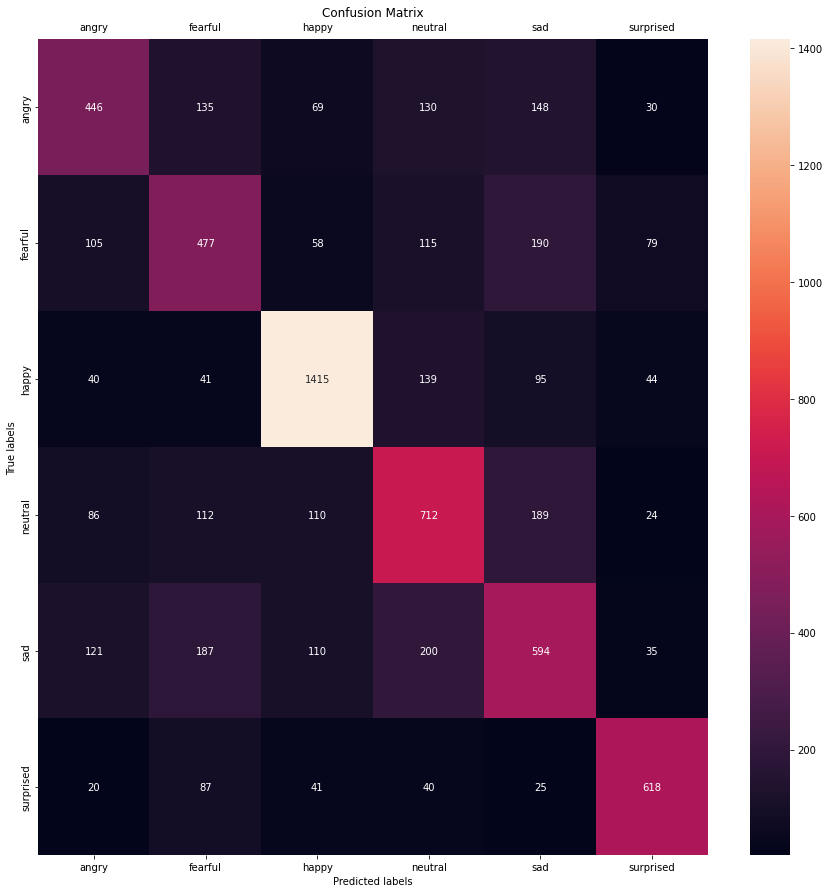

In [13]:
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt     
 
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
ax.xaxis.set_tick_params(labeltop='on')
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
rev = []
for i in range(5,-1,-1):
  rev.append(emotions[i])
ax.xaxis.set_ticklabels(emotions); 
 
ax.yaxis.set_ticklabels(emotions);

In [17]:
# saving the model
model.save('my_model.h5')